In [58]:
# https://www.kaggle.com/competitions/bike-sharing-demand/data
# https://scikit-learn.org/stable/_static/ml_map.png
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 

# Explore the data

In [59]:
train = pd.read_csv("data//train.csv", parse_dates=["datetime"])

In [60]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [62]:
# Column stats
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Feature Engineering

In [63]:
# Reusable vars
analysis_features = ["season", "holiday", "workingday", "weather", "temp","atemp", "humidity", "windspeed", "casual", "registered"]
plot_cols = 3
plot_rows = 4

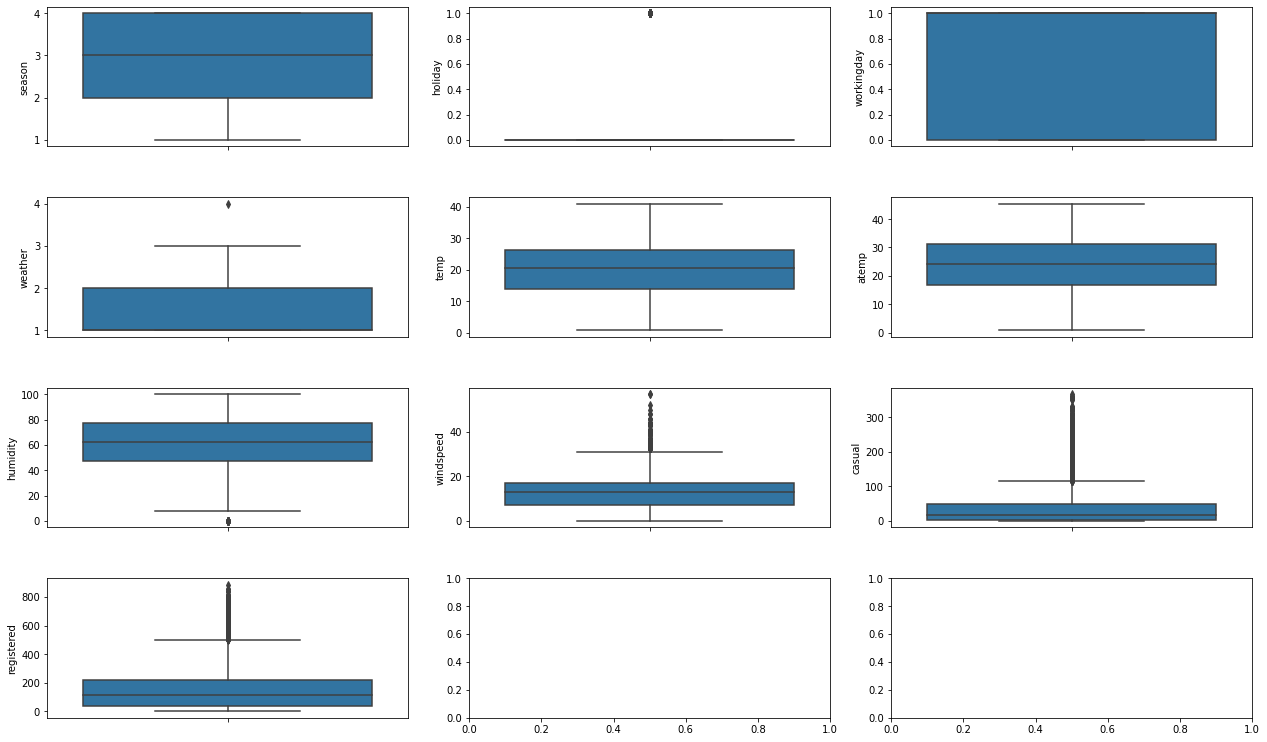

In [64]:
# Visualise outliers with boxplots
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(18, 11))
fig.tight_layout(pad=3.0)
for i in range(len(analysis_features)):
    # Calculate in which slot to draw the next plot
    matrix_coord = axes[i // plot_cols, i % plot_cols]
    sns.boxplot(ax = matrix_coord, y = train[analysis_features[i]])

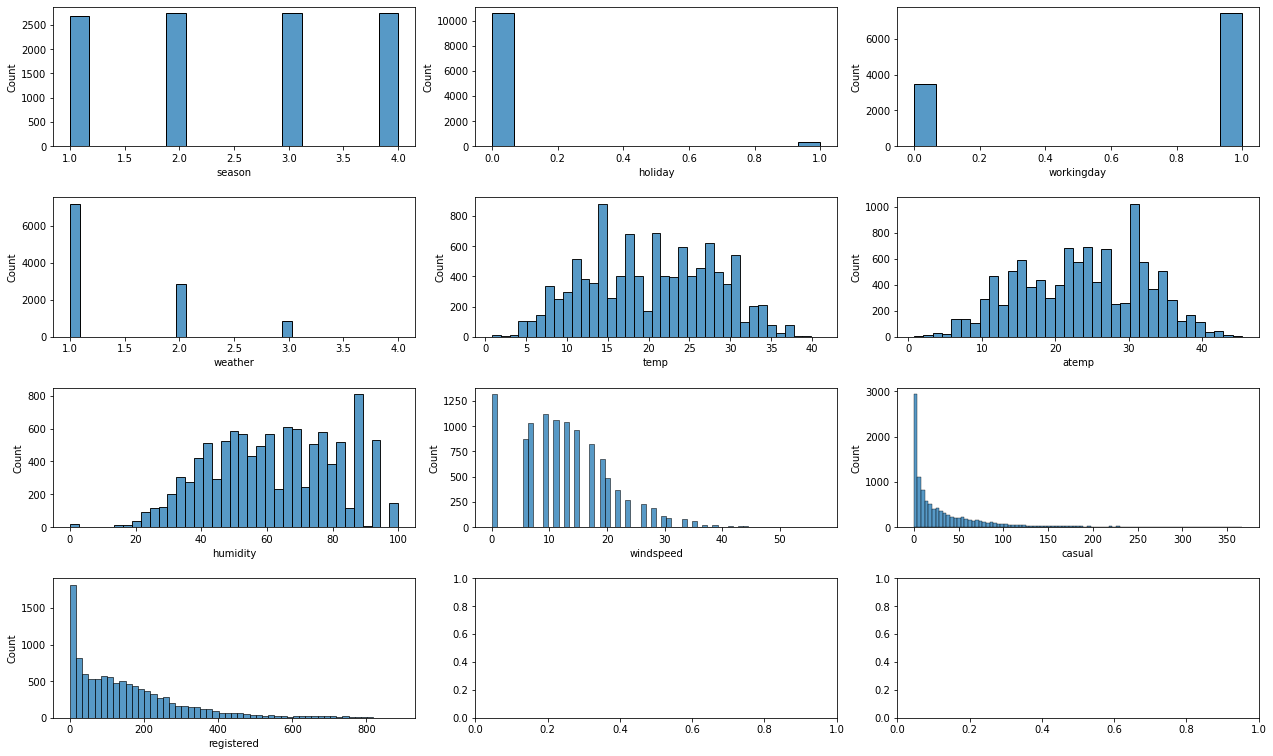

In [65]:
# Visualise series' distributions with histograms
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(18, 11))
fig.tight_layout(pad=3.0)
for i in range(len(analysis_features)):
    # Calculate in which matrix coordinate to draw the next plot
    matrix_coord = axes[i // plot_cols, i % plot_cols]
    sns.histplot(ax = matrix_coord, x = train[analysis_features[i]])

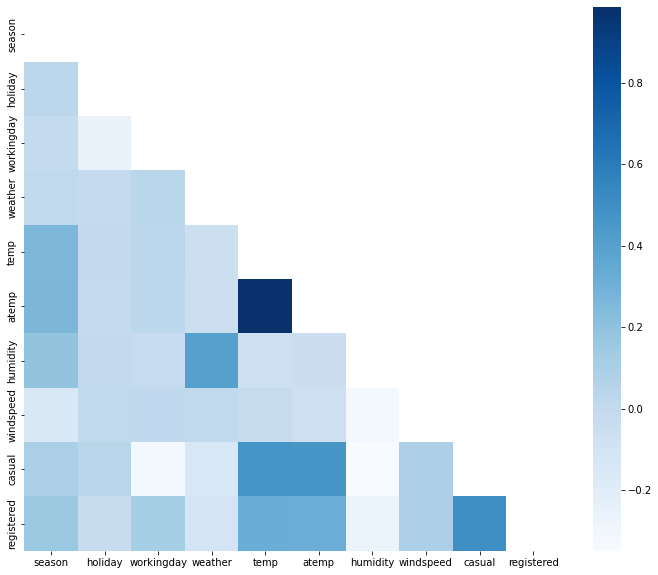

In [66]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
# Calculate correlation between features
cor = train[analysis_features].corr()
top_half_mask = np.zeros_like(cor)
top_half_mask[np.triu_indices_from(top_half_mask)] = True
sns.heatmap(cor, annot = False, cmap = plt.cm.Blues, mask = top_half_mask)
plt.show()

In [67]:
# Create numerical datetime features
train["year"] = train['datetime'].dt.year
train["month"] = train['datetime'].dt.month
train["day"] = train['datetime'].dt.day
train["hour"] = train['datetime'].dt.hour

In [68]:
# Registered and casual are not included in the test dataset
final_features = ["season", "holiday", "workingday", "weather", "atemp", "humidity", "windspeed", "year", "month", "day", "hour"]
train_x = train[final_features]
train_y = train[["count"]]

In [69]:
# Normalize numeric features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Indices of numeric features (column-wise)
numeric_features = list( range( len(final_features) ) )
# Combine preprocessing steps to be used later in a pipeline that pre-processes data and trains model
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

# Model training (Ridge)

In [70]:
# Create the model as pipeline that includes the pre-processing steps and the algorithm
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", Ridge(alpha=0.01))
])
# Train the model
pipeline.fit(train_x, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10])])),
                ('classifier', Ridge(alpha=0.01))])

In [71]:
train_pred = pipeline.predict(train_x)

In [72]:
# Percentage of "accuracy" of the model
print("R^2 : ", r2_score(train_y, train_pred))
# Mean number of bike rentals mispredicted
print("MAE :", mean_absolute_error(train_y,train_pred))
# Generally speaking, use MAE or RMSE, both are included for demo purposes
print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))

R^2 :  0.38916181302577646
MAE : 106.18959897678322
RMSE: 141.5690060915515


In [73]:
test = pd.read_csv("data//test.csv", parse_dates=["datetime"])

# Make predictions for the test set
test["year"] = test['datetime'].dt.year
test["month"] = test['datetime'].dt.month
test["day"] = test['datetime'].dt.day
test["hour"] = test['datetime'].dt.hour

test_x = test[final_features]

test_pred = pipeline.predict(test_x)

In [74]:
pred_series = pd.Series(test_pred.flatten(), name="count")
result = pd.concat((test_x, pred_series), axis="columns")
result["datetime"] = pd.to_datetime(result[["year", "month", "day", "hour"]])
result = result[["datetime", "count"]]
result

,datetime,count
0,2011-01-20 00:00:00,-31.934745
1,2011-01-20 01:00:00,-27.328632
2,2011-01-20 02:00:00,-19.553767
3,2011-01-20 03:00:00,-9.171625
4,2011-01-20 04:00:00,-1.396760
...,...,...
6488,2012-12-31 19:00:00,298.616277
6489,2012-12-31 20:00:00,306.391142
6490,2012-12-31 21:00:00,318.958958
6491,2012-12-31 22:00:00,338.255509


In [75]:
result.to_csv("jc_submission_ridge.csv", index=False)

In [76]:
result.shape

(6493, 2)

# Model Training (Decision Tree Regressor)

In [77]:
# Create the model as pipeline that includes the pre-processing steps and the algorithm
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeRegressor(criterion="friedman_mse", random_state=0))
])
# Train the model
pipeline.fit(train_x, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10])])),
                ('classifier',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       random_state=0))])

In [78]:
train_pred = pipeline.predict(train_x)

In [79]:
print("R^2 : ", r2_score(train_y, train_pred))
print("MAE :", mean_absolute_error(train_y,train_pred))
print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))

R^2 :  1.0
MAE : 0.0
RMSE: 0.0


In [80]:
test = pd.read_csv("data//test.csv", parse_dates=["datetime"])

# Make predictions for the test set
test["year"] = test['datetime'].dt.year
test["month"] = test['datetime'].dt.month
test["day"] = test['datetime'].dt.day
test["hour"] = test['datetime'].dt.hour

test_x = test[final_features]

test_pred = pipeline.predict(test_x)

In [81]:
pred_series = pd.Series(test_pred.flatten(), name="count")
result = pd.concat((test_x, pred_series), axis="columns")
result["datetime"] = pd.to_datetime(result[["year", "month", "day", "hour"]])
result = result[["datetime", "count"]]
result

,datetime,count
0,2011-01-20 00:00:00,15.0
1,2011-01-20 01:00:00,9.0
2,2011-01-20 02:00:00,6.0
3,2011-01-20 03:00:00,4.0
4,2011-01-20 04:00:00,5.0
...,...,...
6488,2012-12-31 19:00:00,340.0
6489,2012-12-31 20:00:00,223.0
6490,2012-12-31 21:00:00,191.0
6491,2012-12-31 22:00:00,138.0


In [82]:
result.to_csv("jc_submission_decisiontreeregressor.csv", index=False)